In [1]:

## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from dataLoader import getDatasetForFCN
from torchsummary import summary


torch.manual_seed(43)  # for reproducibility


------------------ [WindowsPath('../data/simulations/L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p')]


In [2]:


train_data, test_data = getDatasetForFCN(10)
test_data = train_data
print(train_data.__len__())
print(test_data.__len__())


Currently parsing file: L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p
(1, 1278, 60000)
Done, time elapsed: 4.55 

50998
50998


In [3]:

## Helper Functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

BATCH_SIZE = 8
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4)


device = get_default_device()

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(test_dl, device)


In [4]:
mse_loss = nn.MSELoss()


def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b


predictionList = []

def accuracy(outputs, labels):
    preds, _ = torch.max(outputs, dim=1)
    labels = round(labels, decimals=0)
    preds =  round(preds, decimals=0)
    global predictionList

    predictionList += preds
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




class BaseModule(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = mse_loss(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)  
        loss = mse_loss(out, labels)   
        acc = accuracy(out, labels)        
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def train_val_step(self, batch):
        images, labels = batch
        out = self(images)      
        loss = mse_loss(out, labels)
        acc = accuracy(out, labels)        
        return {'train_loss': loss.detach(), 'train_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print("Epoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))
        

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []

    if opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def plotResults(history,name):
    losses = [entry['val_loss'] for entry in history]
    accuracy = [entry["val_acc"] for entry in history]
    train_loss = [entry["train_loss"] for entry in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Model Results')

    ax1.plot(losses, '-o', label="Validation Loss")
    ax1.plot(train_loss, "-s", label="Training Loss")
    ax1.legend()
#     ax1.set_ylim([0,60])
    ax1.set(xlabel = 'Epoch', ylabel="Loss")

    
    ax2.set(xlabel = 'Epoch', ylabel="Values")
    ax2.plot(accuracy, "-r")

    # plt.legend()
    ax1.set_title('Loss vs. Number of Epochs');
    ax2.set_title("Top 1% Accuracy on Validation Set");
    plt.savefig("{}-results.png".format(name))
    plt.show()

    
histories = []

In [5]:
class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 1),
          
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)

C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Validation Loss: 16.2219, Validation Accuracy: 0.1261
Epoch 2, Validation Loss: 13.9757, Validation Accuracy: 0.1197
Epoch 3, Validation Loss: 13.4041, Validation Accuracy: 0.1303
Epoch 4, Validation Loss: 13.4057, Validation Accuracy: 0.1304
Epoch 5, Validation Loss: 13.5307, Validation Accuracy: 0.1280
Epoch 6, Validation Loss: 13.6481, Validation Accuracy: 0.1279
Epoch 7, Validation Loss: 13.7338, Validation Accuracy: 0.1261
Epoch 8, Validation Loss: 13.7917, Validation Accuracy: 0.1240
Epoch 9, Validation Loss: 13.8298, Validation Accuracy: 0.1244
Epoch 10, Validation Loss: 13.8546, Validation Accuracy: 0.1256


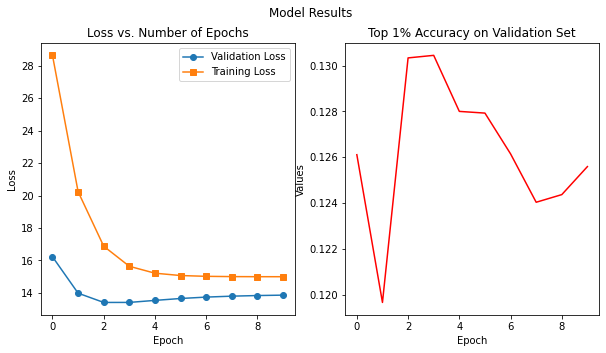

In [6]:
model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")

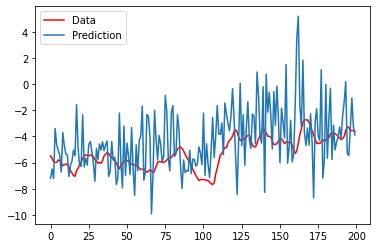

In [7]:


limit = 200 # Change this to alter how many data points you want to look at. 

counter = 0
truthVal = []
pred = []
while counter < limit:
    dataInput, out  = test_data[counter]
   
    truthVal.append(float(out))
    dataInput = torch.transpose(dataInput, 0, 1)
    inputVal = dataInput.float()
    modelres = model(inputVal.to("cuda"))
    pred.append(float(modelres))
    counter+=1
    
plt.figure()
plt.plot(truthVal, "-r", label="Data")
plt.plot(pred, label="Prediction")
plt.legend()
plt.show()

In [5]:
class OneLayerNetV1(BaseModule):
    def __init__(self):
        super(OneLayerNetV1, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 2000), 
            nn.ReLU(),
            nn.Linear(2000, 1),
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)

class OneLayerNetV2(BaseModule):
    def __init__(self):
        super(OneLayerNetV2, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 200), 
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 1),
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)

class OneLayerNetV3(BaseModule):
    def __init__(self):
        super(OneLayerNetV3, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 500), 
            nn.ReLU(),
            nn.Linear(500, 1),
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)

C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Validation Loss: 16.9223, Validation Accuracy: 0.1570
Epoch 2, Validation Loss: 15.2857, Validation Accuracy: 0.1758
Epoch 3, Validation Loss: 13.7728, Validation Accuracy: 0.1709
Epoch 4, Validation Loss: 14.8371, Validation Accuracy: 0.1515
Epoch 5, Validation Loss: 13.4073, Validation Accuracy: 0.1684
Epoch 6, Validation Loss: 13.5179, Validation Accuracy: 0.1651
Epoch 7, Validation Loss: 14.3361, Validation Accuracy: 0.1559
Epoch 8, Validation Loss: 13.6170, Validation Accuracy: 0.1675
Epoch 9, Validation Loss: 14.0678, Validation Accuracy: 0.1646
Epoch 10, Validation Loss: 13.9672, Validation Accuracy: 0.1718


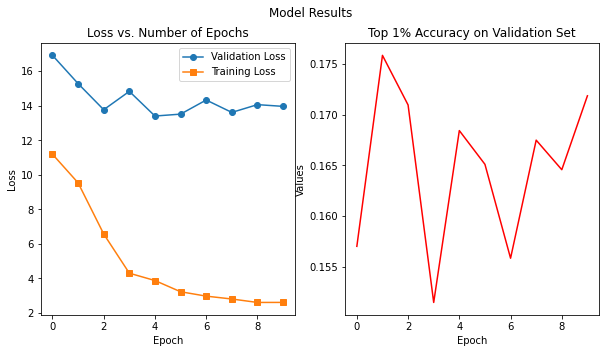

In [6]:
model = to_device(OneLayerNetV1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3 # Learning rate, feel free to experiment with this
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "OneLayerNetV3")

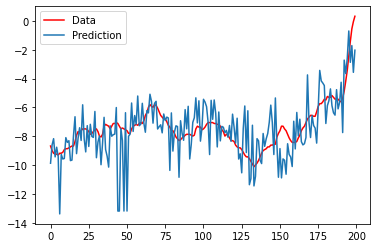

In [7]:

limit = 200 # Change this to alter how many data points you want to look at. 

counter = 0
truthVal = []
pred = []
while counter < limit:
    dataInput, out  = test_data[counter]
   
    truthVal.append(float(out))
    dataInput = torch.transpose(dataInput, 0, 1)
    inputVal = dataInput.float()
    modelres = model(inputVal.to("cuda"))
    pred.append(float(modelres))
    counter+=1
    
plt.figure()
plt.plot(truthVal, "-r", label="Data")
plt.plot(pred, label="Prediction")
plt.legend()
plt.show()

In [ ]:

class ThreeLayerNetV1(BaseModule):
    
    def __init__(self):
        super(ThreeLayerNetV1, self).__init__()
        #net1 will have one hidden layer transforming 1278 inputs to 100 outputs
        # then 100 outputs to 1 predicted soma voltage
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 300),
            nn.ReLU(),
            nn.Linear(300, 300),  
            nn.ReLU(),
            nn.Linear(300, 300),  
            nn.ReLU(),
            nn.Linear(300, 1),
            )
    def forward(self, x):
        x = x.float()    
        res = self.net(x)
    #         print(res)
        return res.to(dtype=torch.float64)

class ThreeLayerNetV2(BaseModule):
    
    def __init__(self):
        super(ThreeLayerNetV2, self).__init__()
        #net1 will have one hidden layer transforming 1278 inputs to 100 outputs
        # then 100 outputs to 1 predicted soma voltage
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1278, 500),  
            nn.ReLU(),
            nn.Linear(500, 500),  
            nn.ReLU(),
            nn.Linear(500, 500),  
            nn.ReLU(),
            nn.Linear(500, 1),
            )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)


class ThreeLayerNetV3(BaseModule):
    
    def __init__(self):
        super(ThreeLayerNetV3, self).__init__()
        #net1 will have one hidden layer transforming 1278 inputs to 100 outputs
        # then 100 outputs to 1 predicted soma voltage
        self.net = nn.Sequential(
            nn.Flatten(),

            nn.Linear(1278, 2000),  
            nn.ReLU(),
            nn.Linear(2000, 2000),  
            nn.ReLU(),
            nn.Linear(2000, 2000),  
            nn.ReLU(),
            nn.Linear(2000, 1),
            )
    def forward(self, x):
        x = x[:,:,0]
        x = x.float()
        res = self.net(x)
#         print(res)
        return res.to(dtype=torch.float64)


   

In [ ]:
model = to_device(ThreeLayerNetV1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3 # Learning rate, feel free to experiment with this
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "ThreeLayerNetV1")